In [53]:
# Use this cell to regroup all your imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import set_config; set_config(display='diagram')

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Loading data

In [2]:
#Importing the data, creating X + y and checking shape
data = pd.read_csv('data/train.csv', index_col='Id')
X = data.drop(columns='SalePrice')
y = data['SalePrice']

X.shape, y.shape

((1460, 79), (1460,))

## 🐣 1. BASELINE

### 1.1 Initial feature overview

In [65]:
#Checking the value counts of each columns dtype
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

How many unique categories are there in total?

In [5]:
#Creating a dataframe only object dtypes
df_cat_only = X[make_column_selector(dtype_include='object')]

#Creating a list of the nunique values in the category dataframe
feat_categorical_nunique_list = []
for i in df_cat_only.columns:
    cat_num = df_cat_only[i].nunique()
    feat_categorical_nunique_list.append(cat_num)

#Turning the above list into a series 
feat_categorical_nunique = pd.Series(feat_categorical_nunique_list, dtype='float64')
cat_names = pd.Series(df_cat_only.columns)

#Total amount of unique categories
feat_categorical_nunique.sum()

252.0

In [9]:
nunique_cat_df = pd.concat([cat_names, feat_categorical_nunique], axis=1)
nunique_cat_df

,0,1
0,MSZoning,5.0
1,Street,2.0
2,Alley,2.0
3,LotShape,4.0
4,LandContour,4.0
5,Utilities,2.0
6,LotConfig,5.0
7,LandSlope,3.0
8,Neighborhood,25.0
9,Condition1,9.0


We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

(array([18., 16.,  4.,  2.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([ 2. ,  4.3,  6.6,  8.9, 11.2, 13.5, 15.8, 18.1, 20.4, 22.7, 25. ]),
 <BarContainer object of 10 artists>)

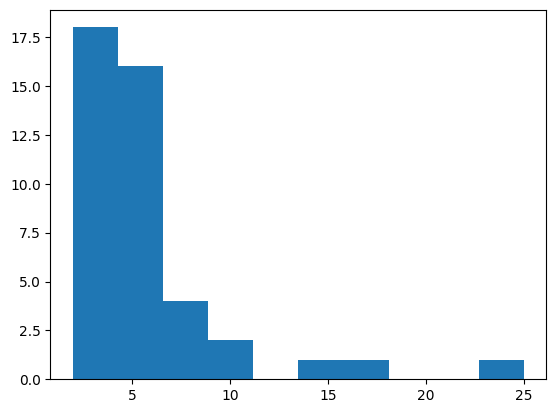

In [68]:
#Plotting a hist of unique categories
plt.hist(feat_categorical_nunique_list)

In [11]:
#Creating a list of large and small categories that we will either drop or adjust
feat_categorical_small = nunique_cat_df[nunique_cat_df[1] < 7][0]
feat_categorical_large = nunique_cat_df[nunique_cat_df[1] > 6][0]

### 1.2 Baseline pipe

#### a) Preprocessing

In [13]:
X_small_cats = X.drop(columns=feat_categorical_large)

#Checking missing values in the dataframe
d_types = X_small_cats.dtypes
empty = X_small_cats.isna().sum()
df_with_nan = pd.concat([d_types, empty], axis=1)
df_with_nan.sort_values(1, ascending=False)

,0,1
PoolQC,object,1453
MiscFeature,object,1406
Alley,object,1369
Fence,object,1179
FireplaceQu,object,690
...,...,...
CentralAir,object,0
MSZoning,object,0
2ndFlrSF,int64,0
LowQualFinSF,int64,0


In [14]:
#Making Column transformers
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown = 'ignore'))

#Isolating columns
num_cols = make_column_selector(dtype_include=['float64', 'int64'])
# cat_cols = make_column_selector(dtype_include=['object'])
cat_cols = list(feat_categorical_small)

#Instantiating the pipeline
preproc_baseline = make_column_transformer((num_transformer, num_cols), 
                                                 (cat_transformer, cat_cols))

In [15]:
preproc_baseline.fit(X)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x176c38250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [17]:
X_preproc = pd.DataFrame(preproc_baseline.transform(X))
X_preproc

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
shape_preproc_baseline = X_preproc.shape
shape_preproc_baseline

(1460, 183)

#### b) Adding estimator

In [27]:
decision_tree = DecisionTreeRegressor()

pipe_basline = make_pipeline(preproc_baseline, decision_tree)

#### c) Cross-Validate

[Contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 

Using make_scorer to create custom scoring metrics
We need rmsle and rmsle_neg - this is for grid searching

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [28]:
def rmsle_func(y, y_pred):
    return np.sqrt(np.sum((np.log(1+y) - np.log(1+y_pred))**2))

def neg_rmsle_func(y, y_pred):
    tot = np.sqrt(np.sum((np.log(1+y) - np.log(1+y_pred))**2))
    return tot * -1

In [29]:
# Testing fucntions
neg_rmsle_func(1300, 1500), rmsle_func(1300, 1500)

(-0.14299835312095688, 0.14299835312095688)

In [30]:
pipe_basline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x176c38250>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [32]:
rmsle = make_scorer(rmsle_func)
neg_rmsle = make_scorer(neg_rmsle_func)

params = {'decisiontreeregressor__max_depth':[3, 7, 11, 14, 25],
          'decisiontreeregressor__min_samples_leaf': [10, 20, 50, 75, 100], 
          'decisiontreeregressor__min_samples_split': [3, 5, 7, 10, 20, 50]
         }

In [33]:
search = GridSearchCV(pipe_basline, param_grid=params, scoring=neg_rmsle, cv=5, n_jobs=1)

In [34]:
search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x176c38250>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_...
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=1,
             param_grid={'decisiontreeregressor__max_depth': [3, 7, 11, 14, 25],
                         'decisiontreeregressor__min_samples_leaf': [10, 20, 50,
                                                                     75, 100],
                         'decisiontreeregressor__min_samples_split': [3, 5, 7,
                                                                      10, 20,
                                                                      50]},
             scoring=make_scorer(neg_rmsle_func))

In [36]:
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x176c38250>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_...
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=1,
             param_grid={'decisiontreeregressor__max_depth': [3, 7, 11, 14, 25],
                         'decisiontreeregressor__min_samples_leaf': [10, 20, 50,
                                                                     75, 100],
                         'decisiontreeregressor__min_samples_split': [3, 5, 7,
                                                                      10, 20,
                                                                      50]},
             scoring=make_scorer(neg_rmsle_func))

In [37]:
search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1714427a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=11, min_samples_leaf=10,
                                       min_samples_split=20))])

In [38]:
score_baseline = search.best_score_
score_baseline

-3.1662180878731916

In [41]:
best_mod = search.best_estimator_

#### d) Predict baseline

In [42]:
test_data = pd.read_csv('data/test.csv', index_col='Id')

In [43]:
y_pred_baseline = best_mod.predict(test_data)

In [44]:
#Creating a dataframe in the format Kaggle requires
baseline_df = pd.DataFrame(y_pred_baseline)
test_ind_df = pd.DataFrame(test_data.index)

submission_df = pd.concat([test_ind_df, baseline_df], axis=1)

In [48]:
submission_df.rename(columns={0:'SalePrice'}, inplace=True)

In [49]:
submission_df

,Id,SalePrice
0,1461,136263.636364
1,1462,163400.000000
2,1463,177693.750000
3,1464,179662.500000
4,1465,226686.444444
...,...,...
1454,2915,84875.000000
1455,2916,92729.411765
1456,2917,111460.000000
1457,2918,114940.000000


In [113]:
# Saving as CSV ready for submission
example = pd.read_csv('data/sample_submission.csv')
submission_df.to_csv('data/submission_baseline.csv', index=False)

## 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a baseline model! You will see now how much easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it online **at least 30 minutes before the Recap ⏳**
- We have some suggestions for improvements below: **Pick your battles** and **incrementally** improve your pipeline as you see fit

**Estimators**

- **Tree-based ensembles (must try today)**: Probably the best suited for problems with many categorical features
- Stacking !
- XGBoost !

**Preprocessing** (once your first ensemble model works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict `log(SalePrice)` instead?
- ...

### 2.1 Preprocessing Iteration ♲ 
(**⚠️ come back here only after you have iterated on your estimators on section 2.2)**

⏩ Collapse me if you don't use me!

#### a) Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how this works

In [54]:
# Define specific order for features
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice
- `preproc_nominal` to one-hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [62]:
data[feat_categorical_large]

,Neighborhood,Condition1,Condition2,HouseStyle,RoofMatl,Exterior1st,Exterior2nd,Functional,SaleType
Id,,,,,,,,,
1,CollgCr,Norm,Norm,2Story,CompShg,VinylSd,VinylSd,Typ,WD
2,Veenker,Feedr,Norm,1Story,CompShg,MetalSd,MetalSd,Typ,WD
3,CollgCr,Norm,Norm,2Story,CompShg,VinylSd,VinylSd,Typ,WD
4,Crawfor,Norm,Norm,2Story,CompShg,Wd Sdng,Wd Shng,Typ,WD
5,NoRidge,Norm,Norm,2Story,CompShg,VinylSd,VinylSd,Typ,WD
...,...,...,...,...,...,...,...,...,...
1456,Gilbert,Norm,Norm,2Story,CompShg,VinylSd,VinylSd,Typ,WD
1457,NWAmes,Norm,Norm,1Story,CompShg,Plywood,Plywood,Min1,WD
1458,Crawfor,Norm,Norm,2Story,CompShg,CemntBd,CmentBd,Typ,WD


In [69]:
data['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

#### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you to **try only Option 1 today to start with**. Option 2 and 3 will be corrected in Recap

##### (Option 1 - recommended) <font color=green>Univariate</font> feature selection based on their mutual information with target `y`

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!
- The statistical test we recommend to pass to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 What is mutual information? Click here!</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [ ]:
# YOUR CODE HERE

##### (option 2) <font color=green>Multivariate</font> feature selection based their combined relationship with target `y`

🤔 We want to remove features that, when in combination with all the others, do not really help predict our target.

1️⃣ To do so, remember that we can use feature [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metric in combination with an estimator! It trains one pipe per feature, so as to estimate which feature makes our performance score *decrease* the most when shuffling it randomly. These would be our most important features, which we don't want to remove. 

The best thing is, scikit-learn allows you to integrate this methodology directly into your `preproc` pipeline thanks to the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) transformer: this will recursively remove least important features according to the `cross_val_score`.

However, this process can take extremely long to train when you have many features.

2️⃣ Alternatively, a faster way would be to make use of models that already output some measure of feature_importance when fitting them. For instance, Trees with gini-based `feature_importance_`, or Lasso regressions with L1 `coef_`. Again here, scikit-learn already has the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that.

In [ ]:
# YOUR CODE HERE

##### (option 3) <font color=green>Unsupervised</font> selection: Filter based only on the properties of `X`? 

❓ A quick win is to remove features with the lowest variance. Think about it: a feature which only has one value is useless (and has a variance of 0).  
- Feel free to add a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) to the end of your pipeline

In [ ]:
# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to check visually whether some **numerical** features almost entirely correlate with others. 
- Use `VIF` from statsmodels to check for features that have the highest multicollinearity

In [ ]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarly to others. Feel free to plot a heatmap again

In [ ]:
# YOUR CODE HERE

❓ Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (Spearman + Pearson) correlation threshold. You'll need a custom transformer class

In [ ]:
# YOUR CODE HERE

#### d) Treat Cyclical features

❓ We have some time-based features, why not **transform them** to cyclical features?

In [ ]:
# YOUR CODE HERE

#### e) Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`?
- Check out the histogram of the target `y`.
- Normally distributed variables should be easier to predict with linear or parametric models. 
- Create `y_log` and your new performance metrics
- Don't forget to take the exponent of your predictions at the end!

In [ ]:
# YOUR CODE HERE

### 2.2 Model Iteration ♻

#### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be and then try many model types to find the best one possible (you can try grid search or go model by model).

In [176]:
forest_params = {'randomforestregressor__n_estimators': [75, 120, 150], 
                 'randomforestregressor__max_depth':[40, 50, 60], 
                 'randomforestregressor__min_samples_split': [2, 3, 7]}

In [177]:
forest = RandomForestRegressor()

preprocess = make_column_transformer((num_transformer, num_cols), 
                                                 (cat_transformer, cat_cols))

forest_pipe = make_pipeline(preprocess, forest)

forest_search = GridSearchCV(forest_pipe, param_grid=forest_params, scoring=neg_rmsle, cv=5, n_jobs=4)

In [178]:
forest_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15204b6a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('randomforestregressor', RandomForestRegressor())])

In [179]:
forest_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x15204b6a0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_...
                                                                          'KitchenQual',
                                                                          'FireplaceQu',
                                                                          'GarageType',
                                                                          'GarageFinish',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                                          'PavedDrive', ...])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'randomforestregressor__max_depth': [40, 50, 60],
                         'randomforestregressor__min_samples_split': [2, 3, 7],
                         'randomforestregressor__n_estimators': [75, 120, 150]},
             scoring=make_scorer(neg_rmsle_func))

In [180]:
forest_search.best_params_, forest_search.best_score_

({'randomforestregressor__max_depth': 40,
  'randomforestregressor__min_samples_split': 2,
  'randomforestregressor__n_estimators': 150},
 -2.488123727864026)

({'randomforestregressor__max_depth': 50,
  'randomforestregressor__min_samples_split': 3,
  'randomforestregressor__n_estimators': 120},
 -2.4908327374548813)

({'randomforestregressor__max_depth': 50,
  'randomforestregressor__min_samples_leaf': 10,
  'randomforestregressor__min_samples_split': 3,
  'randomforestregressor__n_estimators': 75},
 -2.6362181544716785)

In [183]:
for_pred = forest_search.predict(test_data)

In [184]:
for_df = pd.DataFrame(for_pred)
test_ind_df = pd.DataFrame(test_data.index)

for_submission_df = pd.concat([test_ind_df, for_df], axis=1)

for_submission_df.rename(columns={0:'SalePrice'}, inplace=True)

In [186]:
for_submission_df.to_csv('data/submission_ant.csv', index=False)

In [216]:
# x_params = {'xbgregressor__n_estimators': [75, 120, 150],
#             'xbgregressor__max_depth':[40, 50, 60],
#             'xbgregressor__learning_rate': [0.01, 0.1, 1]}

xgb_reg = XGBRegressor(max_depth=50, learning_rate=0.1, n_estimators=200)

xgb_pipe = make_pipeline(preprocess, xgb_reg)

# xgb_search = GridSearchCV(xgb_reg, param_grid=x_params, scoring=neg_rmsle, cv=5, n_jobs=4)

x_cross = cross_validate(xgb_pipe, X, y, scoring=neg_rmsle, cv=5, n_jobs=2)

In [217]:
x_cross['test_score'].mean()

-2.3519304509286543

In [221]:
xgb_pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15204b6a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=50, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [224]:
x_pred = xgb_pipe.predict(test_data)

In [225]:
x_df = pd.DataFrame(x_pred)
test_ind_df = pd.DataFrame(test_data.index)

x_submission_df = pd.concat([test_ind_df, x_df], axis=1)

x_submission_df.rename(columns={0:'SalePrice'}, inplace=True)

In [227]:
x_submission_df.to_csv('data/submission_x.csv', index=False)

In [156]:
# rand_forest_params = {'randomforestregressor__n_estimators': (stats.uniform(30, 120)), 
#                  'randomforestregressor__max_depth':stats.uniform(75, 125), 
#                  'randomforestregressor__min_samples_split': stats.uniform(1, 30)}

# rand_forest = RandomForestRegressor()

# preprocess = make_column_transformer((num_transformer, num_cols), 
#                                                  (cat_transformer, cat_cols))

# rand_forest_pipe = make_pipeline(preprocess, rand_forest)

# rand_forest_search = RandomizedSearchCV(rand_forest_pipe, rand_forest_params, scoring=neg_rmsle, 
#                                    n_iter=15, cv=5, n_jobs=4)

In [170]:
# rand_forest_search.fit(X, y)